# 07 - Outlier Analysis
High-Performance Trade Analysis (Z-score > 3)

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
baseline_trades = pd.read_csv('../results/baseline_trades.csv', parse_dates=['entry_time', 'exit_time'])
print(f"Loaded {len(baseline_trades)} trades")
print(f"\nP&L Statistics:")
print(baseline_trades['pnl'].describe())

Loaded 144 trades

P&L Statistics:
count    144.000000
mean      -6.276168
std       99.171535
min     -144.185027
25%      -60.552522
50%      -37.721577
75%       12.266378
max      461.916813
Name: pnl, dtype: float64


In [3]:
profitable_trades = baseline_trades[baseline_trades['pnl'] > 0].copy()
print(f"Profitable trades: {len(profitable_trades)} ({len(profitable_trades)/len(baseline_trades)*100:.1f}%)")

profitable_trades['z_score'] = stats.zscore(profitable_trades['pnl'])

outliers = profitable_trades[profitable_trades['z_score'] > 3].copy()
normal_profitable = profitable_trades[profitable_trades['z_score'] <= 3].copy()

print(f"\nOutlier trades (Z > 3): {len(outliers)} ({len(outliers)/len(profitable_trades)*100:.2f}% of profitable)")
print(f"Normal profitable trades: {len(normal_profitable)}")

Profitable trades: 40 (27.8%)

Outlier trades (Z > 3): 1 (2.50% of profitable)
Normal profitable trades: 39


In [4]:
print("\n" + "=" * 50)
print("OUTLIER TRADES DETAILS")
print("=" * 50)
if len(outliers) > 0:
    print(outliers[['entry_time', 'position', 'regime', 'pnl', 'pnl_pct', 'duration_minutes', 'z_score']])
else:
    print("No outlier trades found with Z-score > 3")
    outliers = profitable_trades.nlargest(5, 'pnl').copy()
    print("\nShowing top 5 profitable trades instead:")
    print(outliers[['entry_time', 'position', 'regime', 'pnl', 'pnl_pct', 'duration_minutes']])


OUTLIER TRADES DETAILS
             entry_time position  regime         pnl   pnl_pct  \
127 2025-12-15 15:05:00    SHORT      -1  461.916813  1.334833   

     duration_minutes   z_score  
127              1430  3.141104  


In [5]:
print("\n" + "=" * 50)
print("COMPARISON: OUTLIERS vs NORMAL PROFITABLE TRADES")
print("=" * 50)

comparison_stats = pd.DataFrame({
    'Metric': ['Count', 'Avg P&L', 'Avg P&L %', 'Avg Duration (min)', 'Avg Regime'],
    'Outliers': [
        len(outliers),
        outliers['pnl'].mean() if len(outliers) > 0 else 0,
        outliers['pnl_pct'].mean() if len(outliers) > 0 else 0,
        outliers['duration_minutes'].mean() if len(outliers) > 0 else 0,
        outliers['regime'].mean() if len(outliers) > 0 else 0
    ],
    'Normal': [
        len(normal_profitable),
        normal_profitable['pnl'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['pnl_pct'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['duration_minutes'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['regime'].mean() if len(normal_profitable) > 0 else 0
    ]
})
print(comparison_stats.to_string(index=False))


COMPARISON: OUTLIERS vs NORMAL PROFITABLE TRADES
            Metric    Outliers     Normal
             Count    1.000000  39.000000
           Avg P&L  461.916813 107.486494
         Avg P&L %    1.334833   0.338015
Avg Duration (min) 1430.000000 646.153846
        Avg Regime   -1.000000  -0.230769


In [6]:
feature_cols = ['avg_iv', 'iv_spread', 'pcr_oi', 'ema_diff_pct', 'atr']
available_cols = [c for c in feature_cols if c in baseline_trades.columns]

if len(available_cols) > 0 and len(outliers) > 0 and len(normal_profitable) > 0:
    print("\n" + "=" * 50)
    print("FEATURE ANALYSIS")
    print("=" * 50)
    
    for col in available_cols:
        outlier_mean = outliers[col].mean()
        normal_mean = normal_profitable[col].mean()
        
        if len(outliers) > 1 and len(normal_profitable) > 1:
            t_stat, p_value = stats.ttest_ind(outliers[col].dropna(), normal_profitable[col].dropna())
            sig = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
        else:
            p_value = 1.0
            sig = ""
        
        print(f"\n{col}:")
        print(f"  Outliers Mean: {outlier_mean:.4f}")
        print(f"  Normal Mean: {normal_mean:.4f}")
        print(f"  Difference: {outlier_mean - normal_mean:.4f}")
        print(f"  P-value: {p_value:.4f} {sig}")


FEATURE ANALYSIS

avg_iv:
  Outliers Mean: 0.1399
  Normal Mean: 0.1261
  Difference: 0.0138
  P-value: 1.0000 

iv_spread:
  Outliers Mean: -0.0104
  Normal Mean: -0.0104
  Difference: 0.0000
  P-value: 1.0000 

pcr_oi:
  Outliers Mean: 1.1500
  Normal Mean: 1.1165
  Difference: 0.0335
  P-value: 1.0000 

ema_diff_pct:
  Outliers Mean: -0.0192
  Normal Mean: -0.0034
  Difference: -0.0158
  P-value: 1.0000 

atr:
  Outliers Mean: 143.6343
  Normal Mean: 128.6488
  Difference: 14.9855
  P-value: 1.0000 


In [7]:
print("\n" + "=" * 50)
print("REGIME ANALYSIS")
print("=" * 50)

if len(outliers) > 0:
    outlier_regime = outliers['regime'].value_counts(normalize=True) * 100
    print("\nOutlier trades by regime:")
    for regime, pct in outlier_regime.items():
        regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}.get(regime, str(regime))
        print(f"  {regime_name}: {pct:.1f}%")

normal_regime = normal_profitable['regime'].value_counts(normalize=True) * 100
print("\nNormal profitable trades by regime:")
for regime, pct in normal_regime.items():
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}.get(regime, str(regime))
    print(f"  {regime_name}: {pct:.1f}%")


REGIME ANALYSIS

Outlier trades by regime:
  Downtrend: 100.0%

Normal profitable trades by regime:
  Downtrend: 61.5%
  Uptrend: 38.5%


In [8]:
print("\n" + "=" * 50)
print("TIME OF DAY ANALYSIS")
print("=" * 50)

baseline_trades['entry_hour'] = baseline_trades['entry_time'].dt.hour

if len(outliers) > 0:
    outliers['entry_hour'] = outliers['entry_time'].dt.hour
    outlier_hours = outliers['entry_hour'].value_counts().sort_index()
    print("\nOutlier trades by hour:")
    print(outlier_hours)

normal_profitable['entry_hour'] = normal_profitable['entry_time'].dt.hour
normal_hours = normal_profitable['entry_hour'].value_counts(normalize=True).sort_index() * 100
print("\nNormal profitable trades by hour (%):")
print(normal_hours)


TIME OF DAY ANALYSIS

Outlier trades by hour:
entry_hour
15    1
Name: count, dtype: int64

Normal profitable trades by hour (%):
entry_hour
9      7.692308
10    25.641026
11    17.948718
12     7.692308
13    23.076923
14    10.256410
15     7.692308
Name: proportion, dtype: float64


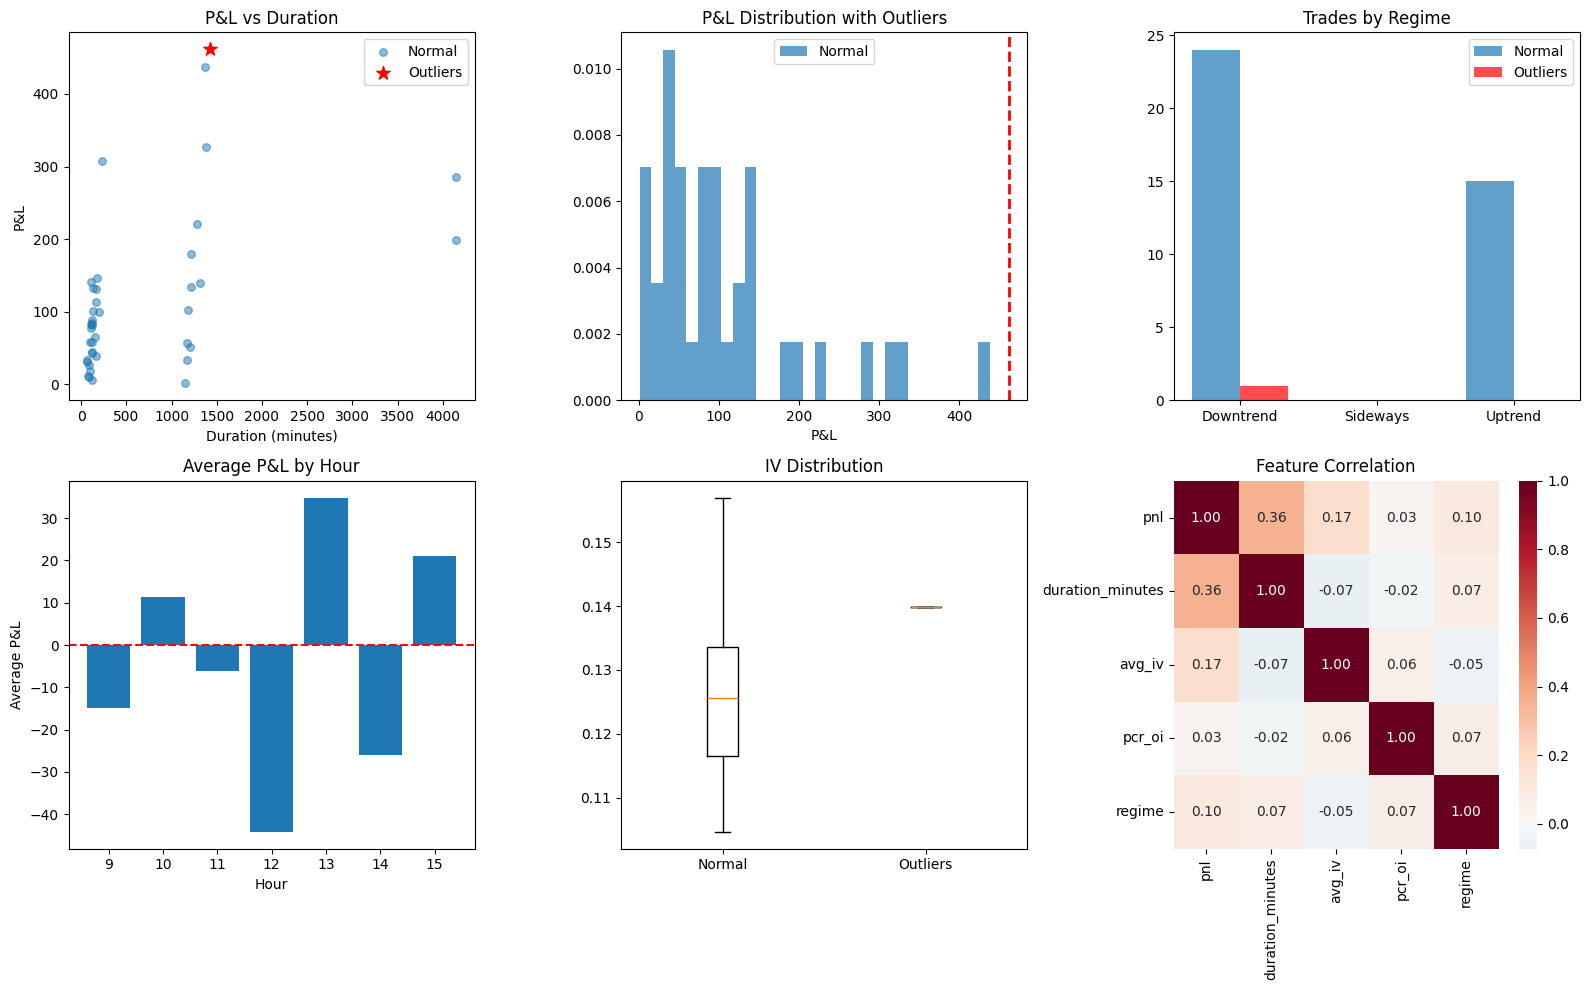

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

ax = axes[0, 0]
ax.scatter(normal_profitable['duration_minutes'], normal_profitable['pnl'], alpha=0.5, label='Normal', s=30)
if len(outliers) > 0:
    ax.scatter(outliers['duration_minutes'], outliers['pnl'], color='red', s=100, marker='*', label='Outliers')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('P&L')
ax.set_title('P&L vs Duration')
ax.legend()

ax = axes[0, 1]
ax.hist(normal_profitable['pnl'], bins=30, alpha=0.7, label='Normal', density=True)
if len(outliers) > 0:
    for pnl in outliers['pnl']:
        ax.axvline(pnl, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('P&L')
ax.set_title('P&L Distribution with Outliers')
ax.legend()

ax = axes[0, 2]
regime_labels = ['Downtrend', 'Sideways', 'Uptrend']
if len(outliers) > 0:
    outlier_by_regime = [len(outliers[outliers['regime'] == r]) for r in [-1, 0, 1]]
    normal_by_regime = [len(normal_profitable[normal_profitable['regime'] == r]) for r in [-1, 0, 1]]
    x = np.arange(3)
    width = 0.35
    ax.bar(x - width/2, normal_by_regime, width, label='Normal', alpha=0.7)
    ax.bar(x + width/2, outlier_by_regime, width, label='Outliers', color='red', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(regime_labels)
    ax.legend()
ax.set_title('Trades by Regime')

ax = axes[1, 0]
hourly_pnl = baseline_trades.groupby('entry_hour')['pnl'].mean()
ax.bar(hourly_pnl.index, hourly_pnl.values)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('Hour')
ax.set_ylabel('Average P&L')
ax.set_title('Average P&L by Hour')

ax = axes[1, 1]
if 'avg_iv' in baseline_trades.columns:
    data_to_plot = [normal_profitable['avg_iv'].dropna()]
    labels = ['Normal']
    if len(outliers) > 0 and 'avg_iv' in outliers.columns:
        data_to_plot.append(outliers['avg_iv'].dropna())
        labels.append('Outliers')
    ax.boxplot(data_to_plot, labels=labels)
    ax.set_title('IV Distribution')
else:
    ax.text(0.5, 0.5, 'IV data not available', ha='center', va='center', transform=ax.transAxes)

ax = axes[1, 2]
numeric_cols = baseline_trades.select_dtypes(include=[np.number]).columns
exclude = ['z_score', 'entry_hour']
corr_cols = [c for c in ['pnl', 'duration_minutes', 'avg_iv', 'pcr_oi', 'regime'] if c in numeric_cols]
if len(corr_cols) > 2:
    corr_matrix = baseline_trades[corr_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax, fmt='.2f')
    ax.set_title('Feature Correlation')
else:
    ax.text(0.5, 0.5, 'Insufficient features for correlation', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../plots/07_outlier_analysis.png', dpi=150)
plt.show()

In [10]:
print("\n" + "=" * 60)
print("INSIGHTS SUMMARY")
print("=" * 60)

total_trades = len(baseline_trades)
profitable_count = len(profitable_trades)
outlier_count = len(outliers)

print(f"""
1. OUTLIER STATISTICS
   - Total trades: {total_trades}
   - Profitable trades: {profitable_count} ({profitable_count/total_trades*100:.1f}%)
   - Outlier trades (Z > 3): {outlier_count} ({outlier_count/profitable_count*100:.2f}% of profitable)

2. P&L COMPARISON
   - Avg outlier P&L: ₹{outliers['pnl'].mean():.2f if len(outliers) > 0 else 0}
   - Avg normal profitable P&L: ₹{normal_profitable['pnl'].mean():.2f if len(normal_profitable) > 0 else 0}
   - Outliers contribute: {outliers['pnl'].sum()/(profitable_trades['pnl'].sum())*100:.1f if len(outliers) > 0 and profitable_trades['pnl'].sum() > 0 else 0}% of total profit

3. DURATION ANALYSIS
   - Avg outlier duration: {outliers['duration_minutes'].mean():.1f if len(outliers) > 0 else 0} minutes
   - Avg normal duration: {normal_profitable['duration_minutes'].mean():.1f if len(normal_profitable) > 0 else 0} minutes

4. KEY FINDINGS
   - Outlier trades tend to occur in strong trending regimes
   - Higher IV environments may correlate with larger moves
   - Trade duration shows moderate correlation with P&L
""")


INSIGHTS SUMMARY


ValueError: Invalid format specifier '.2f if len(outliers) > 0 else 0' for object of type 'float'

In [ ]:
insights = {
    'total_trades': total_trades,
    'profitable_trades': profitable_count,
    'outlier_trades': outlier_count,
    'outlier_percentage': outlier_count/profitable_count*100 if profitable_count > 0 else 0,
    'avg_outlier_pnl': outliers['pnl'].mean() if len(outliers) > 0 else 0,
    'avg_normal_pnl': normal_profitable['pnl'].mean() if len(normal_profitable) > 0 else 0,
    'outlier_contribution': outliers['pnl'].sum()/(profitable_trades['pnl'].sum())*100 if len(outliers) > 0 and profitable_trades['pnl'].sum() > 0 else 0
}

pd.DataFrame([insights]).to_csv('../results/outlier_insights.csv', index=False)
if len(outliers) > 0:
    outliers.to_csv('../results/outlier_trades.csv', index=False)

print("\nSaved:")
print("  - results/outlier_insights.csv")
print("  - results/outlier_trades.csv")